# Model Testing and Comparison Notebook

This notebook provides a framework for testing and comparing different machine learning models for movie genre classification.

## Features:
- Easy model configuration and testing
- Automatic metric calculation and comparison
- Visualization of results
- Support for multiple model types (Logistic Regression, XGBoost, etc.)


In [1]:
# Import required libraries
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    hamming_loss, jaccard_score, confusion_matrix
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time
from typing import Dict, List, Tuple, Any
import json

# Try importing XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠ XGBoost not available. Install with: pip install xgboost")

# Project imports
from descriptions.config import INTERIM_DATA_DIR, MODELS_DIR
from descriptions.dataset import load_interim
from descriptions.modeling.train import prepare_features_and_labels
from descriptions.modeling.preprocess import load_preprocessors

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✓ All imports successful")


2025-12-01 23:16:19.750 | INFO     | descriptions.config:<module>:11 - PROJ_ROOT path is: /Users/christianfullerton/Developer/Python Workspace/movie_genre_model


⚠ XGBoost not available. Install with: pip install xgboost
✓ All imports successful


## 1. Load and Prepare Data


In [2]:
# Load data
print("Loading data...")
data = load_interim(INTERIM_DATA_DIR / "cleaned_movies.csv")
print(f"✓ Loaded {len(data)} samples")
print(f"Columns: {list(data.columns)}")
print(f"\nFirst few rows:")
data.head()


Loading data...
2025-12-01 23:16:21.780 | INFO     | descriptions.dataset:load_interim:99 - Loading interim data from /Users/christianfullerton/Developer/Python Workspace/movie_genre_model/data/interim/cleaned_movies.csv...
2025-12-01 23:16:21.963 | DEBUG    | descriptions.dataset:load_interim:103 - Loaded with index column
2025-12-01 23:16:21.965 | SUCCESS  | descriptions.dataset:load_interim:108 - ✓ Data loaded successfully: 9087 rows, 2 columns
✓ Loaded 9087 samples
Columns: ['genre', 'description']

First few rows:


,genre,description
movie_name,,
he_hawshank_edemption,"Drama, Crime",Imprisoned in the 1940s for the double murder ...
he_odfather,"Drama, Crime","Spanning the years 1945 to 1955, a chronicle o..."
he_odfather_art_,"Drama, Crime",In the continuing saga of the Corleone crime f...
chindlers_ist,"Drama, History, War",The true story of how businessman Oskar Schind...
12_ngry_en,Drama,The defense and the prosecution have rested an...


In [3]:
# Split data into train and test sets BEFORE preprocessing (prevents data leakage)
RANDOM_STATE = 42
TEST_SIZE = 0.2
X, y = data['description'],  data['genre']

print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print("✓ Data split complete")



Splitting data...
✓ Data split complete


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert genre strings to lists of genre strings
# Handle NaN values and split comma-separated genres
def preprocess_genres(genre_series):
    """Convert genre strings to lists of genre strings."""
    return genre_series.fillna("").astype(str).str.split(r"\s*,\s*").apply(
        lambda genres: sorted({g.strip() for g in genres if g.strip()})
    )

print("Preprocessing genres...")
y_train_list = preprocess_genres(y_train)
y_test_list = preprocess_genres(y_test)

print(f"Sample y_train: {y_train_list.iloc[0]}")
print(f"Sample y_test: {y_test_list.iloc[0]}")

# Transform text to TF-IDF features
print("\nTransforming text to TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=10000, 
    ngram_range=(1, 2), 
    stop_words='english'  # Fixed: was 'top_words', should be 'stop_words'
)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

print(f"✓ TF-IDF features: {X_train.shape[1]} features")

# Transform genres to binary labels
print("\nTransforming genres to binary labels...")
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train_list)
y_test = mlb.transform(y_test_list)

print(f"✓ Binary labels: {y_train.shape[1]} genres")
print(f"✓ Training labels shape: {y_train.shape}")
print(f"✓ Test labels shape: {y_test.shape}")



Preprocessing genres...
Sample y_train: ['Horror', 'Mystery']
Sample y_test: ['Adventure', 'Science Fiction', 'Western']

Transforming text to TF-IDF features...
✓ TF-IDF features: 10000 features

Transforming genres to binary labels...
✓ Binary labels: 18 genres
✓ Training labels shape: (7269, 18)
✓ Test labels shape: (1818, 18)


## 2. Grid Search for SGDClassifier


In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score
from descriptions.modeling.evaluate import evaluate_model

# Create base model with OneVsRestClassifier for multi-label classification
model_sgd = OneVsRestClassifier(SGDClassifier(random_state=42))
param_grid = {
    'estimator__loss': ['hinge', 'log_loss', 'modified_huber'],  # Loss functions
    'estimator__penalty': ['l2', 'elasticnet'],  # Regularization types (l1 often slower)
    'estimator__alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength
    'estimator__learning_rate': ['optimal', 'adaptive'],  # Best learning rate schedules
    'estimator__max_iter': [2000, 3000],  # Max iterations
    'estimator__tol': [1e-3, 1e-4],  # Tolerance for stopping
    'estimator__early_stopping': [True],  # Use early stopping (recommended)
}

# Calculate total combinations
total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"Total parameter combinations: {total_combinations}")
print(f"With 5-fold CV: {total_combinations * 5} model fits")
print(f"Estimated time: ~{total_combinations * 5 * 0.5 / 60:.1f} minutes (rough estimate)")

# Create custom scorer for multi-label classification (micro-averaged F1)
def multi_label_f1_micro(y_true, y_pred):
    """Custom scorer for multi-label F1 micro."""
    return f1_score(y_true, y_pred, average='micro', zero_division=0)

scorer = make_scorer(multi_label_f1_micro)

# Grid Search with cross-validation
print("Starting Grid Search for SGDClassifier...")
print(f"Testing parameter combinations with 5-fold CV")
print("="*60)

# Note: This grid search will test multiple combinations
# Consider using the "Quick Grid Search" cell below for faster initial testing

grid_search_sgd = GridSearchCV(
    estimator=model_sgd,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scorer,  # Use custom scorer for multi-label
    n_jobs=-1,  # Use all available cores
    verbose=2,
    return_train_score=True  # Return training scores for analysis
)

print("⚠ Warning: This Grid Search will test many combinations and may take a long time.")
print("Consider reducing param_grid for faster initial testing.")
print("="*60)

grid_search_sgd.fit(X_train, y_train)

print("\n" + "="*60)
print("Grid Search Complete!")
print("="*60)
print(f"Best parameters: {grid_search_sgd.best_params_}")
print(f"Best cross-validation score (F1 micro): {grid_search_sgd.best_score_:.4f}")
print("="*60)

# Get the best model
best_model_sgd = grid_search_sgd.best_estimator_

# Display top results
results_df = pd.DataFrame(grid_search_sgd.cv_results_)
print("\nTop 10 Parameter Combinations:")
top_results = results_df.nlargest(10, 'mean_test_score')[
    ['param_estimator__loss', 'param_estimator__penalty', 'param_estimator__alpha',
     'param_estimator__learning_rate', 'param_estimator__max_iter',
     'mean_test_score', 'std_test_score']
]
print(top_results.to_string(index=False))


Total parameter combinations: 192
With 5-fold CV: 960 model fits
Estimated time: ~8.0 minutes (rough estimate)
Starting Grid Search for SGDClassifier...
Testing parameter combinations with 5-fold CV
⚠ Warning: This Grid Search will test many combinations and may take a long time.
Consider reducing param_grid for faster initial testing.
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resou

[CV] END estimator__alpha=0.0001, estimator__early_stopping=True, estimator__learning_rate=optimal, estimator__loss=hinge, estimator__max_iter=2000, estimator__penalty=l2, estimator__tol=0.001; total time=   1.0s
[CV] END estimator__alpha=0.0001, estimator__early_stopping=True, estimator__learning_rate=optimal, estimator__loss=hinge, estimator__max_iter=2000, estimator__penalty=l2, estimator__tol=0.001; total time=   1.0s
[CV] END estimator__alpha=0.0001, estimator__early_stopping=True, estimator__learning_rate=optimal, estimator__loss=hinge, estimator__max_iter=2000, estimator__penalty=l2, estimator__tol=0.0001; total time=   1.0s
[CV] END estimator__alpha=0.0001, estimator__early_stopping=True, estimator__learning_rate=optimal, estimator__loss=hinge, estimator__max_iter=2000, estimator__penalty=l2, estimator__tol=0.001; total time=   1.0s
[CV] END estimator__alpha=0.0001, estimator__early_stopping=True, estimator__learning_rate=optimal, estimator__loss=hinge, estimator__max_iter=2000

## 3. Evaluate Best SGDClassifier Model


In [6]:
# Evaluate the best model from Grid Search
print("Evaluating Best SGDClassifier Model (from Grid Search)...")
print(f"Best parameters: {grid_search_sgd.best_params_}")
print("="*60)

metrics_sgd = evaluate_model(best_model_sgd, X_test, y_test)

print("\n" + "="*60)
print("BEST SGDCLASSIFIER METRICS (Test Set)")
print("="*60)
print(f"  F1 Score:       {metrics_sgd['f1']:.4f} ({metrics_sgd['f1']*100:.2f}%)")
print(f"  Precision:       {metrics_sgd['precision']:.4f} ({metrics_sgd['precision']*100:.2f}%)")
print(f"  Recall:         {metrics_sgd['recall']:.4f} ({metrics_sgd['recall']*100:.2f}%)")
print(f"  Hamming Loss:   {metrics_sgd['hamming_loss']:.4f} ({metrics_sgd['hamming_loss']*100:.2f}%)")
print(f"  Jaccard Score:  {metrics_sgd['jaccard']:.4f} ({metrics_sgd['jaccard']*100:.2f}%)")
print("="*60)

# Compare with baseline (default SGDClassifier)
print("\nComparing with baseline SGDClassifier (default parameters)...")
baseline_model = OneVsRestClassifier(
    SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=0.0001,
        max_iter=1000,
        random_state=42
    )
)
baseline_model.fit(X_train, y_train)
baseline_metrics = evaluate_model(baseline_model, X_test, y_test)

print(f"\nBaseline F1: {baseline_metrics['f1']:.4f}")
print(f"Best Model F1: {metrics_sgd['f1']:.4f}")
improvement = metrics_sgd['f1'] - baseline_metrics['f1']
print(f"Improvement: {improvement:+.4f} ({improvement/baseline_metrics['f1']*100:+.2f}%)")


Evaluating Best SGDClassifier Model (from Grid Search)...
Best parameters: {'estimator__alpha': 0.0001, 'estimator__early_stopping': True, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'modified_huber', 'estimator__max_iter': 2000, 'estimator__penalty': 'elasticnet', 'estimator__tol': 0.001}
2025-12-01 23:18:36.529 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:111 - Evaluating model: X shape (1818, 10000), y shape (1818, 18)
2025-12-01 23:18:36.532 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:120 - Generating predictions from model...
2025-12-01 23:18:36.566 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:122 - Predictions generated: shape (1818, 18)
2025-12-01 23:18:36.567 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:125 - Calculating evaluation metrics (micro-averaged)...
2025-12-01 23:18:36.646 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:140 - Evaluation metrics calculated successfully

BEST SGDCLASSIFIER

## 4. Visualize Grid Search Results


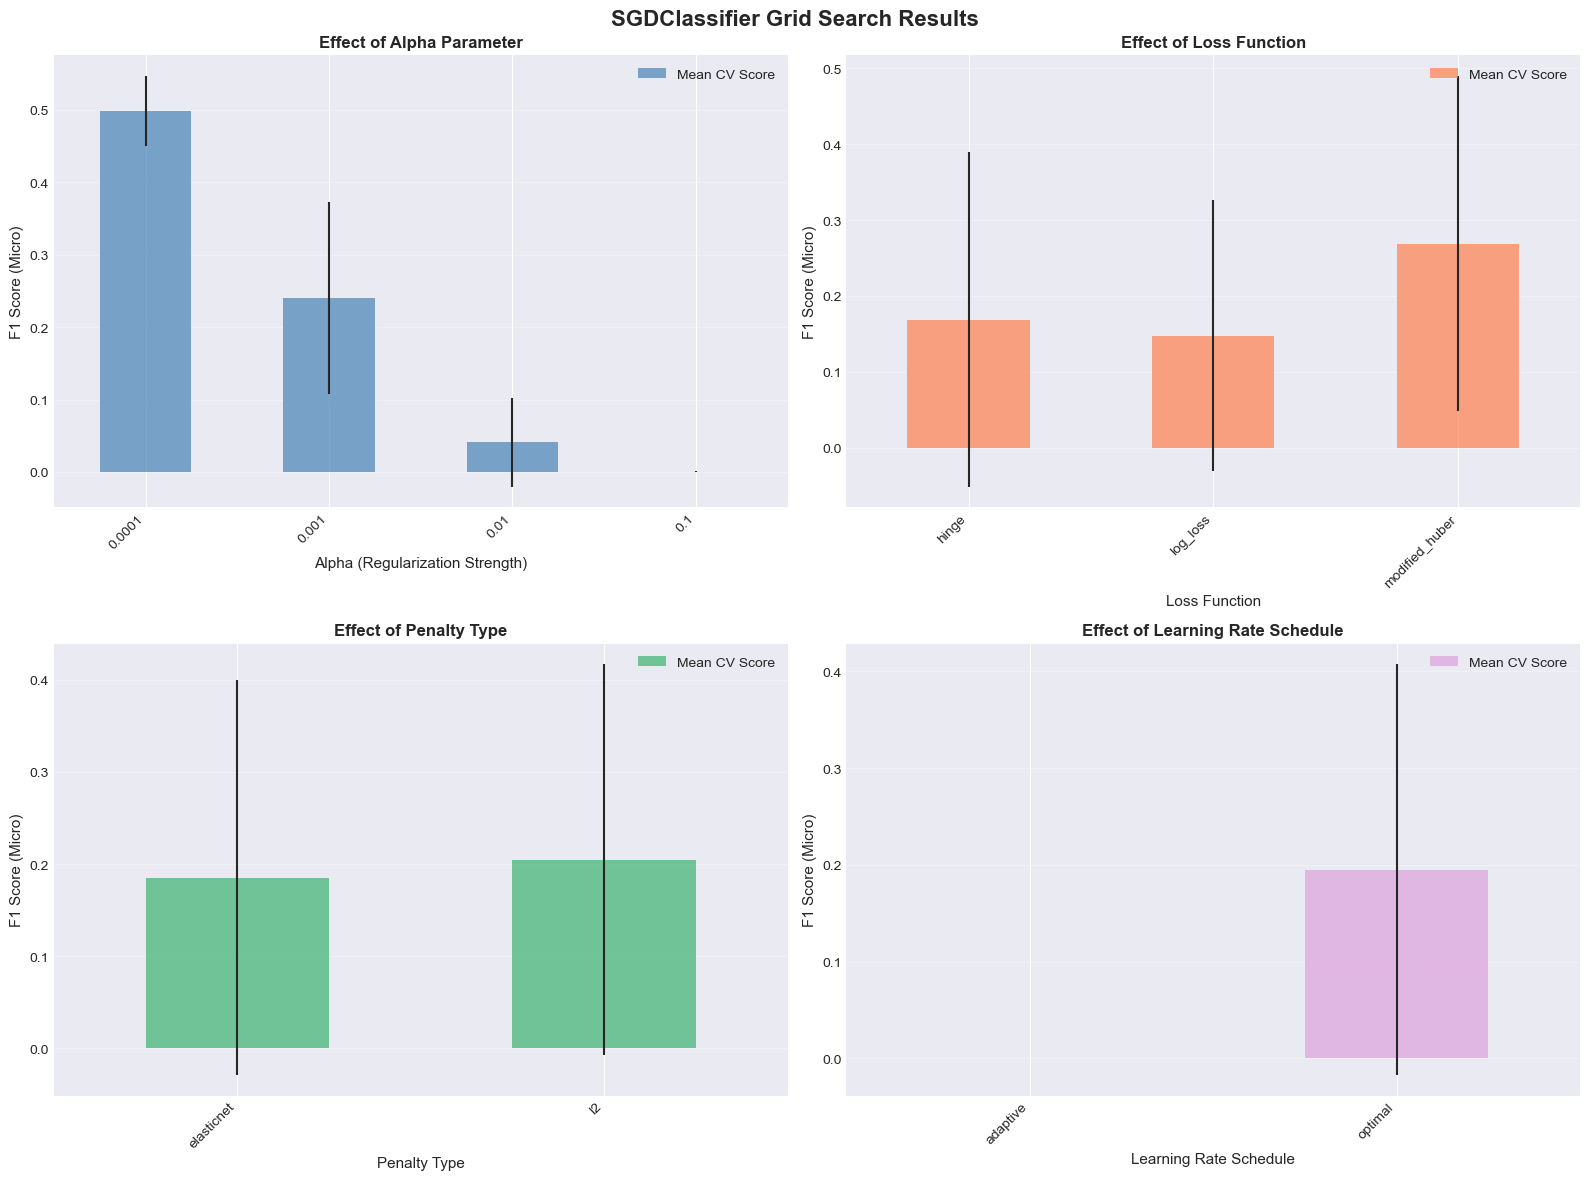


GRID SEARCH SUMMARY STATISTICS
Total combinations tested: 192
Best CV Score: 0.5363
Best Test Score: 0.5520

Best Parameters:
  estimator__alpha: 0.0001
  estimator__early_stopping: True
  estimator__learning_rate: optimal
  estimator__loss: modified_huber
  estimator__max_iter: 2000
  estimator__penalty: elasticnet
  estimator__tol: 0.001


In [7]:
# Visualize Grid Search Results
results_df = pd.DataFrame(grid_search_sgd.cv_results_)

# Plot 1: Effect of alpha (regularization strength)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SGDClassifier Grid Search Results', fontsize=16, fontweight='bold')

# 1. Alpha vs Score
ax1 = axes[0, 0]
alpha_results = results_df.groupby('param_estimator__alpha')['mean_test_score'].agg(['mean', 'std'])
alpha_results.plot(kind='bar', y='mean', yerr='std', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_xlabel('Alpha (Regularization Strength)', fontsize=11)
ax1.set_ylabel('F1 Score (Micro)', fontsize=11)
ax1.set_title('Effect of Alpha Parameter', fontsize=12, fontweight='bold')
ax1.legend(['Mean CV Score'])
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Loss function comparison
ax2 = axes[0, 1]
loss_results = results_df.groupby('param_estimator__loss')['mean_test_score'].agg(['mean', 'std'])
loss_results.plot(kind='bar', y='mean', yerr='std', ax=ax2, color='coral', alpha=0.7)
ax2.set_xlabel('Loss Function', fontsize=11)
ax2.set_ylabel('F1 Score (Micro)', fontsize=11)
ax2.set_title('Effect of Loss Function', fontsize=12, fontweight='bold')
ax2.legend(['Mean CV Score'])
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Penalty type comparison
ax3 = axes[1, 0]
penalty_results = results_df.groupby('param_estimator__penalty')['mean_test_score'].agg(['mean', 'std'])
penalty_results.plot(kind='bar', y='mean', yerr='std', ax=ax3, color='mediumseagreen', alpha=0.7)
ax3.set_xlabel('Penalty Type', fontsize=11)
ax3.set_ylabel('F1 Score (Micro)', fontsize=11)
ax3.set_title('Effect of Penalty Type', fontsize=12, fontweight='bold')
ax3.legend(['Mean CV Score'])
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Learning rate schedule comparison
ax4 = axes[1, 1]
lr_results = results_df.groupby('param_estimator__learning_rate')['mean_test_score'].agg(['mean', 'std'])
lr_results.plot(kind='bar', y='mean', yerr='std', ax=ax4, color='plum', alpha=0.7)
ax4.set_xlabel('Learning Rate Schedule', fontsize=11)
ax4.set_ylabel('F1 Score (Micro)', fontsize=11)
ax4.set_title('Effect of Learning Rate Schedule', fontsize=12, fontweight='bold')
ax4.legend(['Mean CV Score'])
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("GRID SEARCH SUMMARY STATISTICS")
print("="*60)
print(f"Total combinations tested: {len(results_df)}")
print(f"Best CV Score: {grid_search_sgd.best_score_:.4f}")
print(f"Best Test Score: {metrics_sgd['f1']:.4f}")
print(f"\nBest Parameters:")
for key, value in grid_search_sgd.best_params_.items():
    print(f"  {key}: {value}")
print("="*60)


## 5. Quick Grid Search (Faster - Reduced Parameter Space)

For faster testing, use this reduced parameter grid.
